In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.io as sio


2025-11-16 16:42:33,230	INFO worker.py:1718 -- Calling ray.init() again after it has already been called.


Ray initialized with 11 cores for Modin.


In [14]:
dir_participant1 = "Localization/Participant1/"
dir_participant2 = "Localization/Participant2/"

str_radar103 = "103"
str_radar108 = "108"
str_radar109 = "109"

str_patternU = "U"
str_patternD = "diag"
str_patternL = "L"
str_patternG = "gamma"

In [ ]:
# Load radar data for mat files
def load_radar_data(participant_dir, radar_id, pattern):
    base = os.path.join(participant_dir, radar_id, pattern)

    env_mat = sio.loadmat(os.path.join(base, "envNoClutterscans.mat"))
    env_key = [k for k in env_mat.keys() if "env" in k.lower()]
    env = env_mat[env_key[0]]

    r_mat = sio.loadmat(os.path.join(base, "range_bins.mat"))
    r_key = [k for k in r_mat.keys() if "range" in k.lower() or "bin" in k.lower()]
    bins = np.squeeze(r_mat[r_key[0]])

    t_mat = sio.loadmat(os.path.join(base, "T_stmp.mat"))
    t_key = [k for k in t_mat.keys() if "t" in k.lower()]
    ts = np.squeeze(t_mat[t_key[0]])

    return env, bins, ts

# Plot waterfall from loaded env + range_bins
def plot_waterfall_from_env(env, range_bins, title="Waterfall", cmap="viridis"):
    """
    Plot UWB envelope waterfall from already loaded env + range_bins.
    """

    plt.figure(figsize=(10, 6))
    plt.imshow(
                env.T,
                aspect="auto",
                origin="lower",
                extent=[0, env.shape[0], range_bins[0], range_bins[-1]],
                cmap=cmap,
    )
    plt.colorbar(label="Envelope Magnitude")
    plt.xlabel("Slow Time / Scan Number")
    plt.ylabel("Fast Time / Range (m)")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(f"{title}.png", dpi=300)
    plt.show()

# Time windows
def generate_time_windows(t_list, window_size=0.25, step=0.125):
    t_min = max(t[0] for t in t_list)
    t_max = min(t[-1] for t in t_list)

    windows = []
    t = t_min
    while t + window_size <= t_max:
        windows.append((t, t + window_size))
        t += step
    return windows

# Radii per window (cap strongest bins)
def get_radii_for_window(env, bins, ts, t_start, t_end, thresh=5e4, top_k=4):
    """
    Return up to top_k range values (meters) whose envelope exceeds thresh
    in the given time window.
    """
    mask = (ts >= t_start) & (ts <= t_end)
    idx = np.where(mask)[0]
    if idx.size == 0:
        return np.array([])

    env_win = env[idx, :]
    env_max = env_win.max(axis=0)

    active = np.where(env_max > thresh)[0]
    if active.size == 0:
        return np.array([])

    if active.size > top_k:
        strongest = active[np.argsort(env_max[active])[-top_k:]]
        active = strongest

    return bins[active]

# Build track in RANGE space (no geometry)
def compute_range_track_2radar(
    env108, b108, t108,
    env109, b109, t109,
    windows,
    thresh=5e4
):
    """
    For each window, pick a representative distance from each radar
    (mean of active bins) and return arrays:
        x_vals = ranges from Radar 109
        y_vals = ranges from Radar 108
    """
    x_vals = []  # Radar 109
    y_vals = []  # Radar 108

    for (ts, te) in windows:
        r108 = get_radii_for_window(env108, b108, t108, ts, te, thresh)
        r109 = get_radii_for_window(env109, b109, t109, ts, te, thresh)

        if r108.size == 0 or r109.size == 0:
            continue

        # representative radius per radar (you could also use min/max)
        y_vals.append(r108.mean())
        x_vals.append(r109.mean())

    return np.array(x_vals), np.array(y_vals)

# Plot track in range–range plane
def plot_range_track(x109, y108, title="Pattern tracking (range space)"):
    """
    Scatter plot of:
        x-axis: distance from Radar 109
        y-axis: distance from Radar 108
    This uses no assumed positions in the room.
    """
    plt.figure(figsize=(6, 6))
    plt.scatter(x109, y108, c='r', s=15, label='observed')

    plt.title(title)
    plt.xlabel("Feet side Radar 109 (range, m)")
    plt.ylabel("Window wall Radar 108 (range, m)")
    plt.grid(True)
    plt.gca().set_aspect('equal', 'box')

    # optional: auto-limits from data, or clamp to [0,4]
    plt.xlim(0, max(4, x109.max() + 0.2))
    plt.ylim(0, max(4, y108.max() + 0.2))

    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{title}.png", dpi=300)
    plt.show()

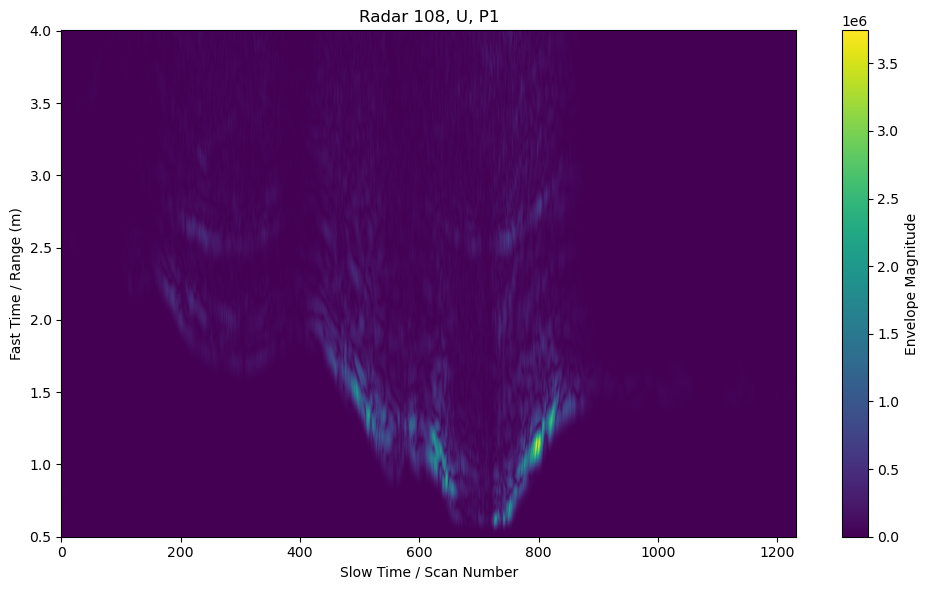

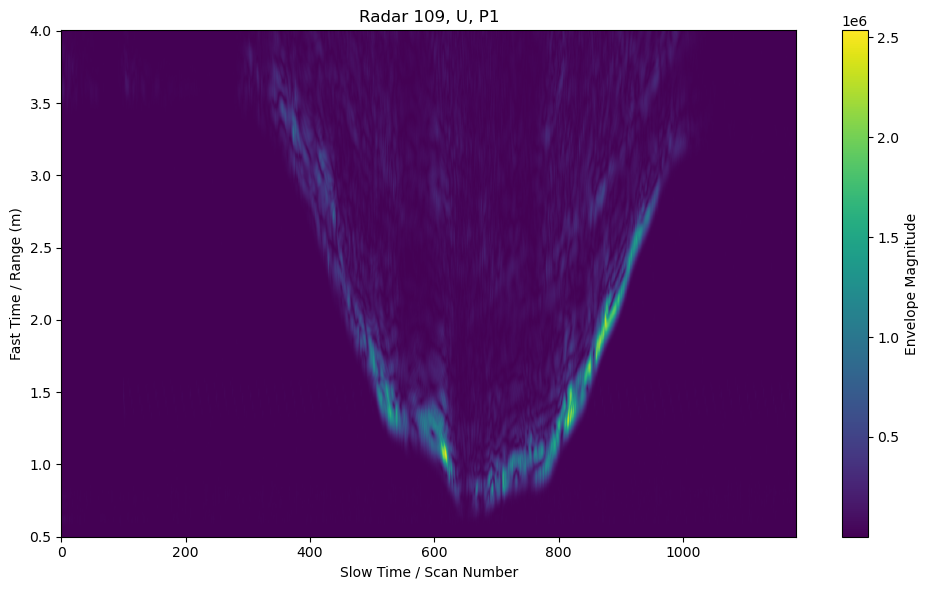

In [16]:
env108U, b108U, t108U = load_radar_data(dir_participant1, str_radar108, str_patternU)
env109U, b109U, t109U = load_radar_data(dir_participant1, str_radar109, str_patternU)
plot_waterfall_from_env(env108U, b108U, title="Radar 108, U, P1")
plot_waterfall_from_env(env109U, b109U, title="Radar 109, U, P1")

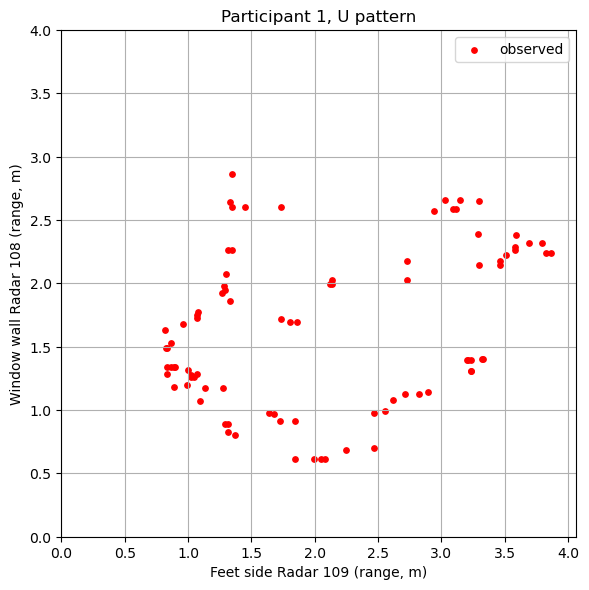

In [17]:
# common windows (no location assumptions)
windowsU = generate_time_windows([t108U, t109U])

# build range-space track
x109U, y108U = compute_range_track_2radar(
                                            env108U, b108U, t108U,
                                            env109U, b109U, t109U,
                                            windowsU,
                                            thresh=5e4
)
# plot
plot_range_track(x109U, y108U, title="Participant 1, U pattern")

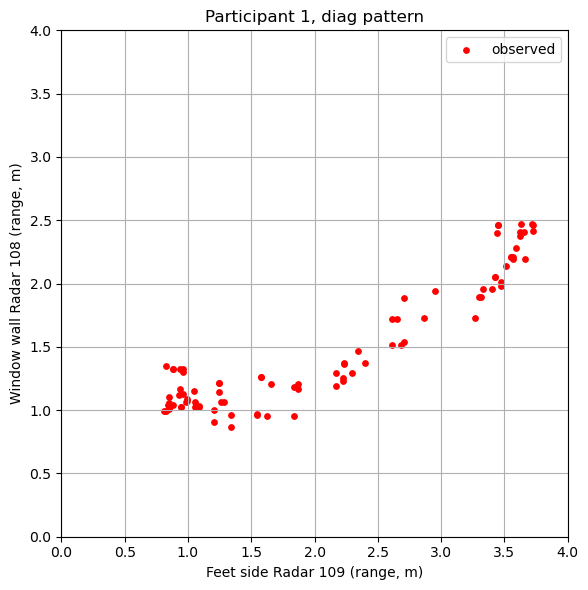

In [18]:
# load 108 and 109 for Participant 1, "diag"
env108D, b108D, t108D = load_radar_data(dir_participant1, str_radar108, str_patternD)
env109D, b109D, t109D = load_radar_data(dir_participant1, str_radar109, str_patternD)

# common windows
windowsD = generate_time_windows([t108D, t109D])

# build range-space track
x109D, y108D = compute_range_track_2radar(
                                            env108D, b108D, t108D,
                                            env109D, b109D, t109D,
                                            windowsD,
                                            thresh=5e4
)

# plot
plot_range_track(x109D, y108D, title="Participant 1, diag pattern")

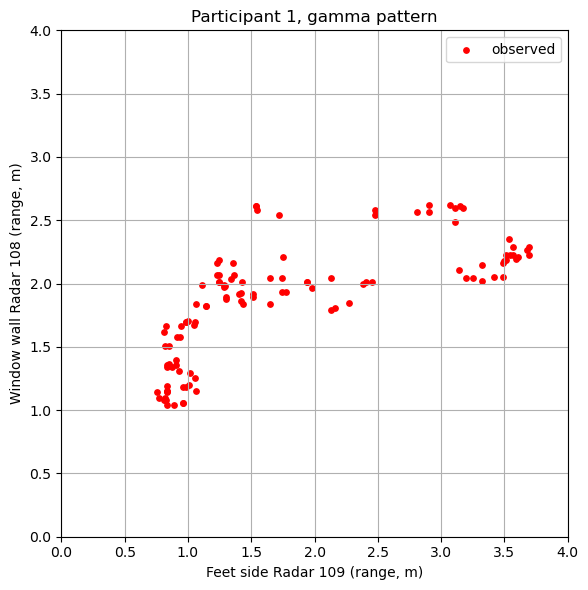

In [19]:
# load 108 and 109 for Participant 1, "gamma"
env108G, b108G, t108G = load_radar_data(dir_participant1, str_radar108, str_patternG)
env109G, b109G, t109G = load_radar_data(dir_participant1, str_radar109, str_patternG)

# common windows
windowsG = generate_time_windows([t108G, t109G])

# build range-space track
x109G, y108G = compute_range_track_2radar(
                                            env108G, b108G, t108G,
                                            env109G, b109G, t109G,
                                            windowsG,
                                            thresh=5e4
)

# 4) plot
plot_range_track(x109G, y108G, title="Participant 1, gamma pattern")


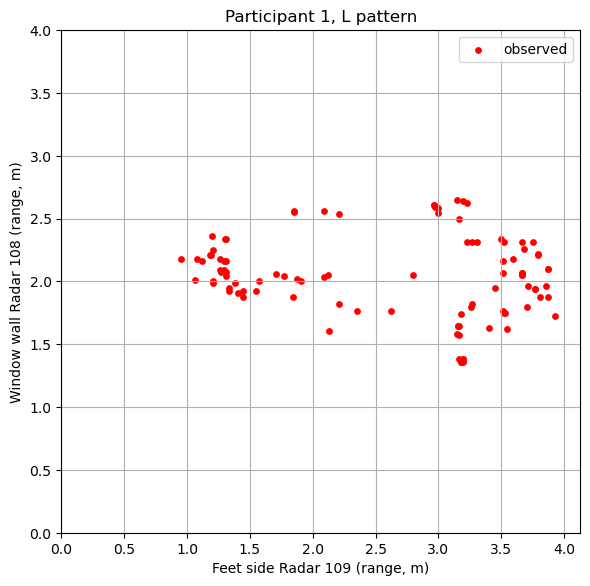

In [20]:
# load 108 and 109 for "L"
env108L, b108L, t108L = load_radar_data(dir_participant1, str_radar108, str_patternL)
env109L, b109L, t109L = load_radar_data(dir_participant1, str_radar109, str_patternL)

# common windows
windowsL = generate_time_windows([t108L, t109L])

# build range-space track
x109L, y108L = compute_range_track_2radar(
                                            env108L, b108L, t108L,
                                            env109L, b109L, t109L,
                                            windowsL,
                                            thresh=5e4
    )

plot_range_track(x109L, y108L, title="Participant 1, L pattern")

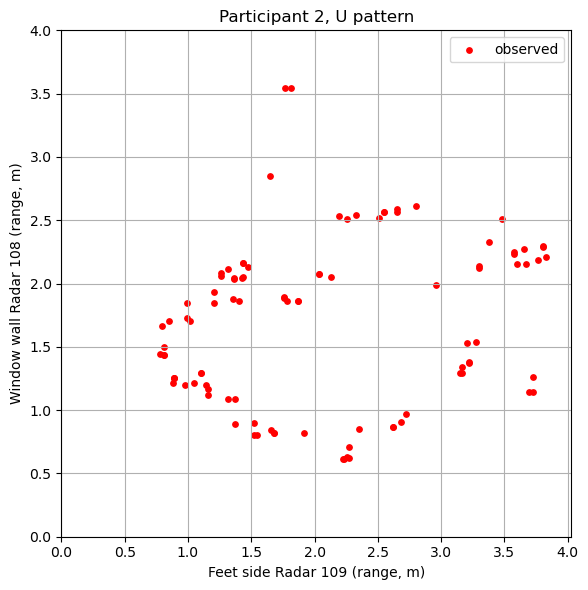

In [21]:
# load 108 and 109 for Participant 2, "U"
env108U, b108U, t108U = load_radar_data(dir_participant2, str_radar108, str_patternU)
env109U, b109U, t109U = load_radar_data(dir_participant2, str_radar109, str_patternU)

# common windows (no location assumptions)
windowsU = generate_time_windows([t108U, t109U])

# build range-space track
x109U, y108U = compute_range_track_2radar(
                                            env108U, b108U, t108U,
                                            env109U, b109U, t109U,
                                            windowsU,
                                            thresh=5e4
)
# plot
plot_range_track(x109U, y108U, title="Participant 2, U pattern")

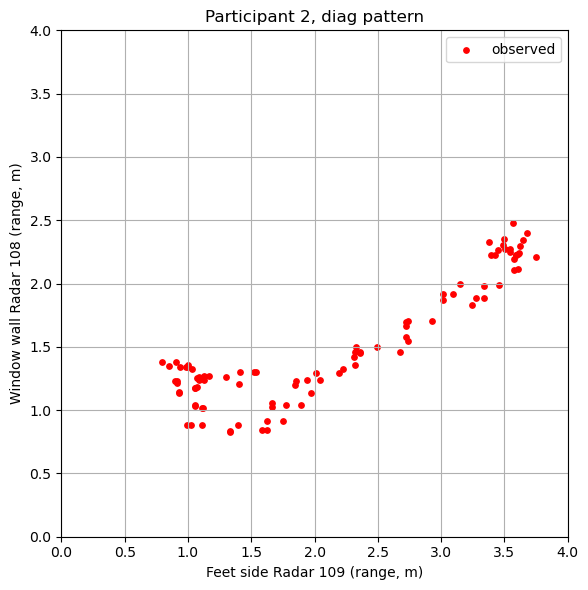

In [22]:
# load 108 and 109 for Participant 2, "diag"
env108D, b108D, t108D = load_radar_data(dir_participant2, str_radar108, str_patternD)
env109D, b109D, t109D = load_radar_data(dir_participant2, str_radar109, str_patternD)

# common windows
windowsD = generate_time_windows([t108D, t109D])

# build range-space track
x109D, y108D = compute_range_track_2radar(
                                            env108D, b108D, t108D,
                                            env109D, b109D, t109D,
                                            windowsD,
                                            thresh=5e4
)

# plot
plot_range_track(x109D, y108D, title="Participant 2, diag pattern")

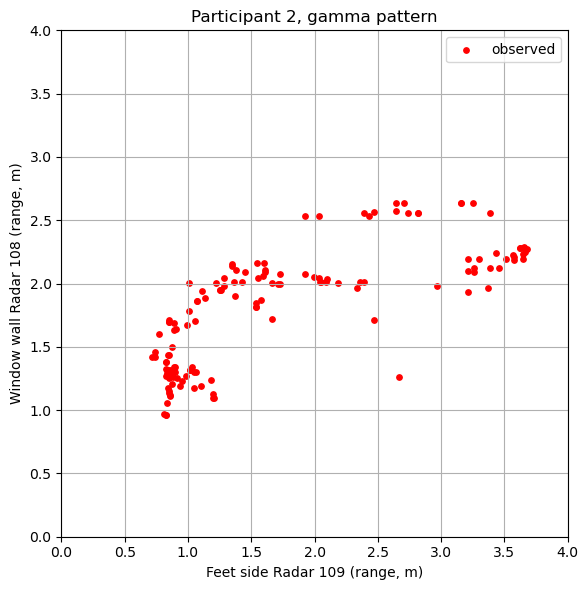

In [23]:
# load 108 and 109 for Participant 2, "gamma"
env108G, b108G, t108G = load_radar_data(dir_participant2, str_radar108, str_patternG)
env109G, b109G, t109G = load_radar_data(dir_participant2, str_radar109, str_patternG)

# common windows
windowsG = generate_time_windows([t108G, t109G])

# build range-space track
x109G, y108G = compute_range_track_2radar(
                                            env108G, b108G, t108G,
                                            env109G, b109G, t109G,
                                            windowsG,
                                            thresh=5e4
)

# 4) plot
plot_range_track(x109G, y108G, title="Participant 2, gamma pattern")

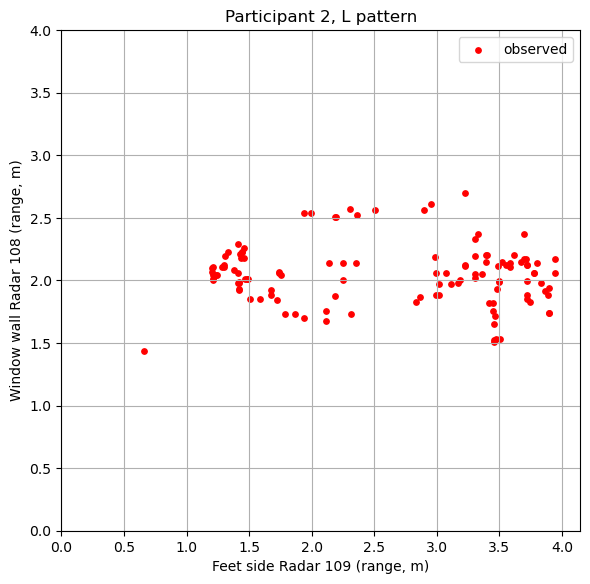

In [24]:
# load 108 and 109 for "L"
env108L, b108L, t108L = load_radar_data(dir_participant2, str_radar108, str_patternL)
env109L, b109L, t109L = load_radar_data(dir_participant2, str_radar109, str_patternL)

# common windows
windowsL = generate_time_windows([t108L, t109L])

# build range-space track
x109L, y108L = compute_range_track_2radar(
                                        env108L, b108L, t108L,
                                        env109L, b109L, t109L,
                                        windowsL,
                                        thresh=5e4
)

plot_range_track(x109L, y108L, title="Participant 2, L pattern")